# Análises COVID-19

### Autor: José Gabriel dos Santos Pádua



## Instalando o pdarima

In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 94.0 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


## Instalando o fbprophet, fiz esses comandos

lembrando que aqui utilizei o google colab.

In [14]:
import io, os, sys, setuptools, tokenize

In [ ]:
!pip install prophet

## Bibliotecas necessárias

In [88]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import re
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import prophet
from IPython.display import clear_output

In [83]:
path = '/content/covid_19_data.csv'

df = pd.read_csv(path, parse_dates=['ObservationDate', 'Last Update'])
df

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26708,26709,2020-05-19,Wyoming,US,2020-05-20 02:32:19,776.0,10.0,0.0
26709,26710,2020-05-19,Xinjiang,Mainland China,2020-05-20 02:32:19,76.0,3.0,73.0
26710,26711,2020-05-19,Yukon,Canada,2020-05-20 02:32:19,11.0,0.0,11.0
26711,26712,2020-05-19,Yunnan,Mainland China,2020-05-20 02:32:19,185.0,2.0,183.0


Função para poder arrumar as colunas e deixá-las de uma maneira mais simples de utilizar.

In [84]:
def corrige_colunas(col_name):
    return re.sub(r"[/| ]", "", col_name).lower()

In [85]:
df.columns = [corrige_colunas(col) for col in df.columns]

## Casos Confirmados

aqui é feito uma filtragem da região brasil e casos confirmados.

In [86]:
brasil = df.loc[(df.countryregion == 'Brazil') & (df.confirmed > 0)]

## Gráfico: Data x Número de casos confirmados


In [90]:
fig = px.line(
        brasil, 'observationdate', 'confirmed', 
        labels={'observationdate':'Data', 'confirmed':'Número de casos confirmados'},
        title='Casos confirmados no Brasil',
        template='ggplot2',
        width=1280,
        height=720
)

clear_output(wait=True)

go.Figure(fig).show()


## Número de novos casos por dia

In [31]:
# Função para contagem de novos casos

brasil['novoscasos'] = list(map(
    lambda x: 0 if (x==0) else brasil['confirmed'].iloc[x] - brasil['confirmed'].iloc[x-1],
    np.arange(brasil.shape[0])
))

<ipython-input-31-5ad2762748c0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Gráfico: Data x Novos casos

In [40]:
px.line(
    brasil, x='observationdate', y='novoscasos', title='Novos casos por dia',
    labels={'observationdate': 'Data', 'novoscasos': 'Novos casos'},
    template='ggplot2',
    color_discrete_sequence=['darkred'],
    width=1280,
    height=720
)

## Gráfico: Data x Mortes

In [43]:
#Fazendo o gráfico

fig = go.Figure()

fig.add_trace(
    go.Scatter(
         x=brasil.observationdate,
         y=brasil.deaths, 
         name='Mortes', 
         mode='lines+markers',
         marker=dict(
             color='darkred',
             size=5,
             symbol='circle',
             line=dict(
                 color='black'
            )
        )
    )
)

#Edita o layout
fig.update_layout(
    title='Mortes por COVID-19 no Brasil',
    xaxis_title='Data',
    yaxis_title='Número de mortes',
    width=1280,
    height=720,
    font=dict(
        family='Arial',
        size=16,
        color='black'
    )
)

fig.show()

## Taxa de crescimento

In [46]:
def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):

    # Se data_inicio for None, define como a primeira data disponível no dataset
    
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    if data_fim == None:
        data_fim = data.observationdate.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)
    
    # Define os valores de presente e passado
    passado = data.loc[data.observationdate == data_inicio, variable].values[0]
    presente = data.loc[data.observationdate == data_fim, variable].values[0]
    
    # Define o número de pontos no tempo
    n = (data_fim - data_inicio).days
    
    # Calcula a taxa
    taxa = (presente/passado)**(1/n) - 1

    return taxa*100

In [48]:
cresc_medio = taxa_crescimento(brasil, 'confirmed')
print(f"O crescimento médio do COVID no Brasil no período avaliado foi de {cresc_medio.round(2)}%.")

O crescimento médio do COVID no Brasil no período avaliado foi de 16.27%.


## taxa de crescimento diária.

In [50]:
def taxa_crescimento_diaria(data, variable, data_inicio=None):
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    data_fim = data.observationdate.max()
    n = (data_fim - data_inicio).days
    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1,n+1)
    ))
    return np.array(taxas)*100

In [52]:
tx_dia = taxa_crescimento_diaria(brasil, 'confirmed')
tx_dia

array([  0.        ,   0.        , 100.        ,   0.        ,
         0.        ,   0.        , 100.        ,   0.        ,
       225.        ,   0.        ,  53.84615385,  25.        ,
        24.        ,  22.58064516,  36.84210526, 190.38461538,
         0.        ,   7.28476821,  23.45679012,  60.5       ,
        15.88785047,  66.93548387,  27.69726248,  28.75157629,
        51.4201763 ,  24.45019405,  16.78794179,  13.66266133,
        16.87548943,  14.47236181,  14.25226807,   9.01639344,
         7.58928571,  24.8525879 ,  19.57320273,  17.67115272,
        12.58080557,  14.39929329,   7.43243243,   9.26325247,
        15.40169394,  15.22017956,  11.88620903,   8.54521335,
         5.54537122,   7.06807546,   5.57858688,   7.81903542,
        12.10513815,   7.4329096 ,  10.70501233,   8.83557983,
         5.44492335,   5.4043566 ,   5.73350023,   6.21648599,
         9.35157462,   8.00823407,   9.77184834,   6.36504619,
         6.88748019,   8.58316283,   8.80726429,   9.41

## Gráfico: Data x Taxa de crescimento

In [54]:
primeiro_dia = brasil.observationdate.loc[brasil.confirmed > 0].min()

px.line(
    x=pd.date_range(primeiro_dia, brasil.observationdate.max())[1:],
    y=tx_dia, 
    title='Taxa de crescimento de casos confirmados no Brasil',
    labels={'y':'Taxa de crescimento', 'x':'Data'},
    template='ggplot2',
    width=1280,
    height=720
)

## Predições

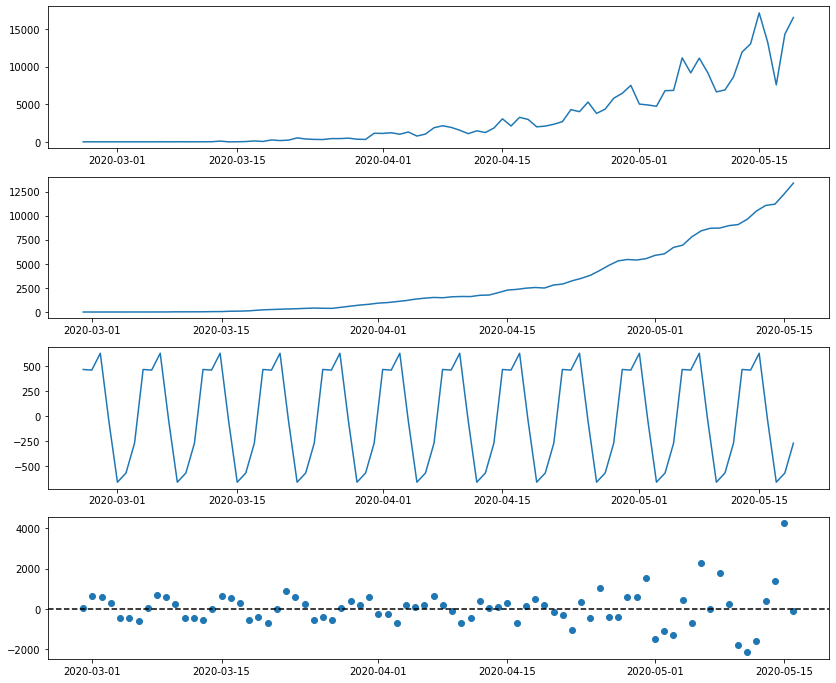

In [61]:
novoscasos = brasil.novoscasos
novoscasos.index = brasil.observationdate

res = seasonal_decompose(novoscasos)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(14, 12))
ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.scatter(novoscasos.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

In [60]:
## Decompondo a série de confirmados

In [63]:
confirmados = brasil.confirmed
confirmados.index = brasil.observationdate

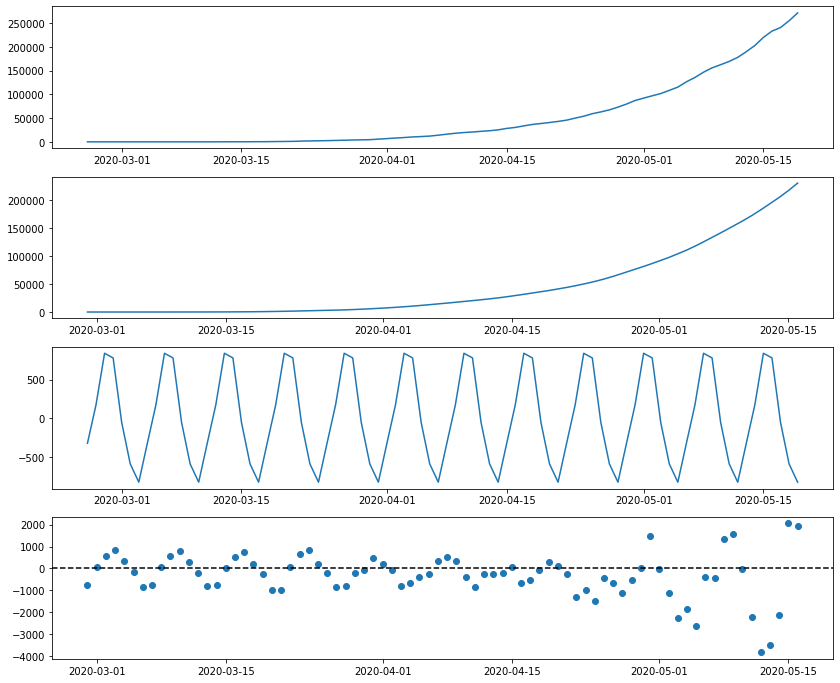

In [65]:
res2 = seasonal_decompose(confirmados)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(14,12))
ax1.plot(res2.observed)
ax2.plot(res2.trend)
ax3.plot(res2.seasonal)
ax4.scatter(confirmados.index, res2.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

# Predizendo o número de casos confirmados com um AUTO-ARIMA

In [67]:
modelo = auto_arima(confirmados)

In [68]:
pd.date_range('2020-05-01', '2020-05-19')

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
               '2020-05-17', '2020-05-18', '2020-05-19'],
              dtype='datetime64[ns]', freq='D')

## Gráfico de predição

In [70]:
fig = go.Figure(go.Scatter(
    x=confirmados.index, 
    y=confirmados, name='Observed'
))

fig.add_trace(go.Scatter(
    x=confirmados.index, 
    y = modelo.predict_in_sample(), 
    name='Predicted'
))

fig.add_trace(go.Scatter(
    x=pd.date_range('2020-05-20', '2020-06-05'), 
    y=modelo.predict(15), name='Forecast'))

fig.update_layout(
    title='Previsão de casos confirmados para os próximos 15 dias',
    yaxis_title='Casos confirmados', 
    xaxis_title='Data')

fig.show()

## Forecasting com Facebook Prophet

In [80]:
# preparando os dados
train = confirmados.reset_index()[:-5]
test = confirmados.reset_index()[-5:]

# renomeia colunas
train.rename(columns={"observationdate":"ds","confirmed":"y"},inplace=True)
test.rename(columns={"observationdate":"ds","confirmed":"y"},inplace=True)
test = test.set_index("ds")
test = test['y']


# Como eu importei a biblioteca desssa maneira: import prophet, tive que criar uma instância dessa forma.

# phophet.Prophet()

profeta = prophet.Prophet(growth="logistic", changepoints=['2020-03-21', '2020-03-30', '2020-04-25', '2020-05-03', '2020-05-10'])

#pop = 1000000
pop = 211463256 #https://www.ibge.gov.br/apps/populacao/projecao/box_popclock.php
train['cap'] = pop

# Treina o modelo
profeta.fit(train)

# Construindo previsões para o futuro
future_dates = profeta.make_future_dataframe(periods=200)
future_dates['cap'] = pop
forecast =  profeta.predict(future_dates)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptoo1uefo/bxkmcbye.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptoo1uefo/0u5mugcf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86231', 'data', 'file=/tmp/tmptoo1uefo/bxkmcbye.json', 'init=/tmp/tmptoo1uefo/0u5mugcf.json', 'output', 'file=/tmp/tmptoo1uefo/prophet_model991pa87b/prophet_model-20230225151956.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:19:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:19:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [81]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=forecast.ds, 
    y=forecast.yhat, 
    name='Predição'
))

fig.add_trace(go.Scatter(
    x=test.index, 
    y=test, 
    name='Observados - Teste'
))

fig.add_trace(go.Scatter(
    x=train.ds, 
    y=train.y, 
    name='Observados - Treino'
))

fig.update_layout(title='Predições de casos confirmados no Brasil')

fig.show()